# LSTM-Based Timse Series forecasting
* https://www.youtube.com/watch?v=hIQLy5zCgH4&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi&index=48
* https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_2_lstm.ipynb


So far, the neural networks that we’ve examined have always had forward connections. Neural networks of this type always begin with an input layer connected to the first hidden layer. Each hidden layer always connects to the next hidden layer. The final hidden layer always connects to the output layer. This manner of connection is why these networks are called “feedforward.” Recurrent neural networks are not as rigid, as backward linkages are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself. Most recurrent neural network architectures maintain the state in the recurrent connections. Feedforward neural networks don’t keep any state.

In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cuda


## Understanding LSTM
Long Short Term Memory (LSTM) layers are a type of recurrent unit that you often use with deep neural networks.
LSTM makes use of two transfer function types internally.


The first type of transfer function is the sigmoid. This transfer function type is used form gates inside of the unit. The sigmoid transfer function is given by the following equation:

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

The second type of transfer function is the hyperbolic tangent (tanh) function, which allows you to scale the output of the LSTM. This functionality is similar to how we have used other transfer functions in this course.

We provide the graphs for these functions here:

Sigmoid


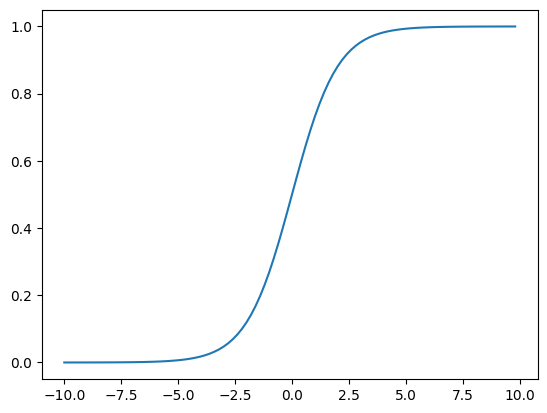

Tanh


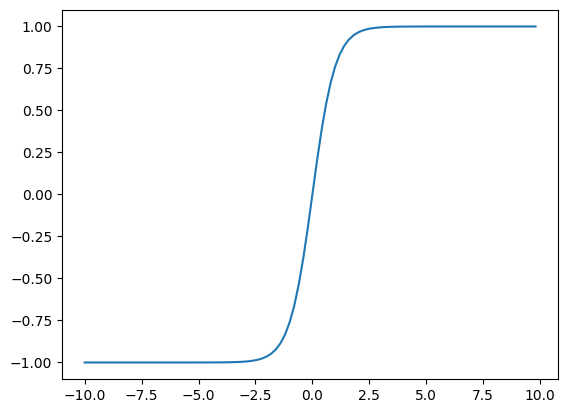

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a= []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x, y1)
plt.show()

print("Tanh")
plt.plot(x, y2)
plt.show()

Both of these two functions compress their output to a specific range. For the sigmoid function, this range is 0 to 1. For hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output. The following diagram shows as LSTM unit over three timselices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice, as demonstrated by under Figure.

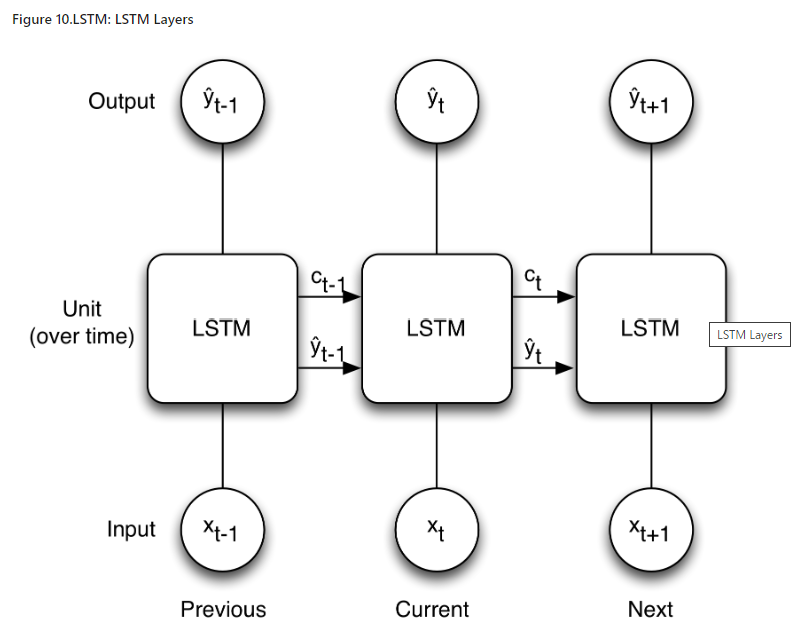

In [ ]:
from PIL import Image

im = Image.open('/content/drive/MyDrive/study_DeepLearning/pytorch_youtube/images/016_lstm_layer.png')
im

The values $\hat{y}$ are the output from the unit; the values ($x$) are the input to the unit, and the values $c$ are the context values. The output and context values always feed their output to the next time slice. The context values allows the network to maintain the state between cells. Under figure shows the internals of a LSTM layer.

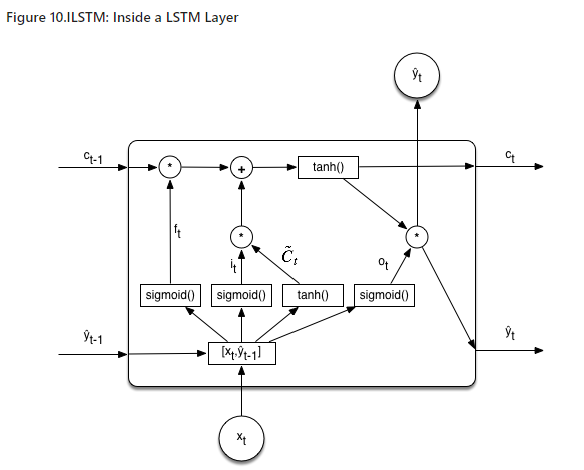

In [ ]:
im = Image.open('/content/drive/MyDrive/study_DeepLearning/pytorch_youtube/images/016_lstm_inner.png')
im

A LSTM unit consists of three gates:
* Forget Gate ($f_t$) - Controls if/when the context is forggoten. (MC)
* Input Gate ($i_t$) - Controls if/when the context should remember a values (M +/ MS)
* Output Gate ($o_t$) - Controls if/when the remembered value is allowed to pass from the unit (RM).


## Sun Spots Example
We begin by loading and preparing data for the LSTM model. Next, we define a list of the column headers for a dataset. Following that, we read a CSV file from the given URL using the `pd.read_csv` function. this dataset is sunspot activity. The CSV is provided by the UDA government and has certain specifications:
* It uses a semicolon (;) as a separator.
* The dataset doesn't have a header, so the header=None argument ensures pandas doesn't mistakenly take the first row as column names. Instead, the predefined names list is used as the columns' header.
* Any value of '-1' in the dataset is considered as a missing value (na_values=['-1']).
* The dataset is read without setting an index column (index_col=False), meaning the default integer index will be used.
* Once executed, this code will load the specified dataset into a pandas DataFrame named df.

In [2]:
# Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

df

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1
...,...,...,...,...,...,...,...,...
72860,2017,6,26,2017.484,21,1.1,25,0
72861,2017,6,27,2017.486,19,1.2,36,0
72862,2017,6,28,2017.489,17,1.1,22,0
72863,2017,6,29,2017.492,12,0.5,25,0


Next we perform data preprocessing tasks for the sunspot dataset. Initially, the code identifies the last occurrence where the `obs_num` column has a value, this is to strip off incomplete data near the beginning of the file. The **sn_value** column of the dataframe is then converted into floating-point numbers, ensuring numerical computations are consistent. After this, the dataframe is split into two parts based on the 'year' column: any data prior to the year 2000 is assigned to **df_train**, and data from the year 2000 onwards is assigned to **df_test**. Subsequently, the **sn_value** column from both the training and testing dataframes is extracted, transformed into numpy arrays, and reshaped to form 2D arrays with a single column.


This restructuring is done to meet the input requirements of PyTorch. The final segment of the code focuses on data normalization. A StandardScaler is initialized, which is a tool to standardize data to have a mean of 0 and a standard deviation of 1. This scaler is trained on the training data and then used to normalize both the training and testing data. After normalization, both datasets are flattened and converted to lists, resulting in one-dimensional lists of normalized **sn_value** data for both training and testing purposes.

In [3]:
# Data Preprocessing
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1 # obs_numが0のレコードの最後のindexの次のindexを取得
df = df[start_id:].copy()
df.head()

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused1
11314,1848,12,23,1848.977,353,23.8,1,1
11315,1848,12,24,1848.980,240,19.6,1,1
11316,1848,12,25,1848.982,275,21.0,1,1
11317,1848,12,26,1848.985,352,23.8,1,1
11318,1848,12,27,1848.988,268,20.8,1,1


In [4]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1) # 2次元化 - StandardScaler用
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1) # 2次元化 - StandardScaler用

spots_train

array([[353.],
       [240.],
       [275.],
       ...,
       [103.],
       [ 66.],
       [ 79.]])

In [5]:
# normalization
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

spots_train[:10]

[3.370924724576519,
 1.9389109571846703,
 2.3824550444299333,
 3.3582520363695116,
 2.293746226980881,
 2.509181926500008,
 3.244197842506444,
 3.2061797778854215,
 1.9135655807706553,
 2.5345273029140234]

The following code prepares the sequence data. This must be done in tasks like time series prediction or sequenctial data processing. The primary goal is to transform a list of observations into overlapping sequences of a specified length.

The constant **SEQUENCE_SIZE** is set to 10, meaning that each sequence (or window) will consist of 10 observations.

The function **to_sequences** is defined to facilitate this transformation. This function takes in two arquments: the size of each sequence (seq_size) and the list of observations (obs). Within the function, two empty lists, **x** and **y**, are intialized. Iterating over the **obs** list, for every index **i**, a window of size **seq_size** is extracted from **obs** and appended to the **x** list. The observation immediatedly following this window, or the (i + seq_size)-th observation, is appended to the **y** list. Essentially, **x** contains the sequences, and **y** contains the observations immediately following each sequence that are to be predicted. Once the lists are filled, they're converted into PyTorch tensors with the appropriate shapes and data type (torch.float32).


Using this **to_sequences** function, the previously prepared **spots_train** and **spots_test** lists are transformed into their corresponding sequence datasets: **x_train**, **y_train**, **x_test**, and **y_test**. In this setup, if we consider **x_train** and **x_test**, each entry will represent a sequence of 10 observations, and the corresponding entry in **y_train** or **y_test** will represent the observation immediately following the sequence. This structure is particularly useful for tasks like predicting the next value in a time series based on a sequence of previous values.

In [6]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)

    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

In [7]:
print(x_train.shape)
display(x_train[-1])

torch.Size([55150, 10, 1])


tensor([[ 0.5196],
        [ 0.5449],
        [ 0.4562],
        [ 0.5956],
        [ 0.5196],
        [ 0.3675],
        [ 0.1014],
        [-0.0254],
        [ 0.2028],
        [-0.2661]])

[55150, 10, 1] - [面の数, 行の数, 列の数]

In [8]:
print(y_train.shape)
display(y_train[-3:])


torch.Size([55150, 1])


tensor([[ 0.2028],
        [-0.2661],
        [-0.1014]])

Next we set up data loaders for PyTorch, a crucial step when training neural networks in batches. First, the training data (**x_train** and **y_train**) is encapsulated a **TensorDataset**. This structure pairs input data and its corresponding target, making it easier to manage. Similarly, the testing data (**x_test** and **y_test**) is also wrapped into a **TensorDataset**. Once the datasets are structured, they are passed to the **DataLoader** function.


For the training data, a **DataLoader** is created with a batch size of 32, and the shuffle parameter is set to True, which means the during each epoch of training, the training data will be divided into batches of 32 samples, and these batches will be randomly shuffled. This shuffling is to ensure the model isn't exposed to any inherent order in the data during training, promoting better generalization.


Conversely, for the testing data, while the batch size remains 32, the shuffle parameter is set to False, indicating that the order of the test data remains unchanged. This is typical as shuffling the test data isn't necessary and can often make evaluation metrics easier to interpret. By the end of this code, two data loaders (train_loader and test_loader) are established, ready to feed data in batched to a neural network during both training and evaluation phases.

In [9]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 10, 1])
torch.Size([32, 1])


We define an **LSTMModel** class, which is a neural network architecture using PyTorch that provides more precise control than a sequence. This model is structured with an LSTM layer followed by a dropout layer for regularization and two subsequent fully connected layers. The LSTM layer processes input sequences, producing a series of hidden states. The model then utilizes only the last hidden state of this series, passing it through the dropout layer and the two linear layers in sequence. This architecture is geared towards processing sequential data, where the LSTM can capture temporal dependencies and the fully connected layers further refine the representation for the final output.

In [11]:
# Model definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = LSTMModel().to(device)

The code outlines the training process for a neural network model. It sets up a mean squared error (MSE) loss function and uses the Adam optimizer with a learning rate of 0.001. The learning rate scheduler, **ReduceLROnPlateau**, adjusts the learning rate when the validation loss plateaus(安定状態), decreasing it by a factor of 0.5 if there's no improvement for three epochs. The model trains for a maximum of 1000 epochs but incorporates early stopping; if the validation loss doesn't improve for filve consecutive epochs, the training halts prematurely. During each epoch, the model's weights are updated using the training data. Subsequently, the model's performance is evaluated on the validation data, and the average validation loss is computed. The progress of the training, including the current epoch and corresponding validation loss, is printed the console.

In [12]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print(f"Early stopping at epoch {epoch}")
        break
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 0.0349
Epoch 2/1000, Validation Loss: 0.0340
Epoch 3/1000, Validation Loss: 0.0379
Epoch 4/1000, Validation Loss: 0.0346
Epoch 5/1000, Validation Loss: 0.0366
Epoch 6/1000, Validation Loss: 0.0344
Early stopping at epoch 6


Finally, we evaluate the PyTorch neural network model on test data. It initiates by setting the model to evaluation mode using **model.eval**, which ensures that specific layers like dropout are fixed during inference. The predictions list is initialized to store the model's predictions on the test data. The **torch.no_grad** context is used to disable gradient calculations, optimizing memory usage and speed during evaluation. Inside this context, the code iterates over the **test_loader** to fetch(取ってくる) batches of test data.


Each data batch is then transferred to the computing device, and the model is subsequently used to gegnerate predictions on this batch. These predictions are added to the predictions list. After processing all test batches, the code calculates the Root Mean Square Error (RMSE) between the predicted values and the actual targets (**y_test**). Notably, the predictions and targets are inverse-transformed using the scaler to revert(元に戻す) the normalization and compute the RMSE in the original data scale. The computed RMSE, a measure of prediction error, is then printed to the console.

In [14]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))

print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 14.5990
